In [1]:
import sys
import os
import importlib
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

%config InlineBackend.figure_format = "retina"

/scratch/local/jobs/4690200/ipykernel_236204/3551025195.py:20: UserWarning: Trying to register the cmap 'diverging' which already exists.
  mpl.colormaps.register(cm_div, force=True)


In [5]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape, rf161_arr.shape)

(4150115, 2) (4150115, 60) (4150115, 3)


In [6]:
# load committors
q = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns
w = np.load(
    "../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[0]

In [7]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [8]:
steps, q_inds = bin_inds(q, qstep=0.1, low=0.45, hi=0.55)

In [9]:
steps

array([0.45])

In [10]:
q_inds

[array([  29613,   73388,   73389, ..., 4130315, 4130320, 4130460])]

In [11]:
# states to compare
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186

# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [12]:
X = np.hstack((cv_arr, sb_arr[:, 30:], rf161_arr))

In [13]:
down_cv = X[down_ids]
up_cv = X[up_ids]
down_avgs = np.mean(down_cv, axis=0)
up_avgs = np.mean(up_cv, axis=0)

In [14]:
ts_cv =  X[q_inds[0]]
ts_avgs = np.mean(ts_cv, axis=0)

In [15]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}-F161")

In [16]:
for name, d, u, t in zip(feature_names, down_avgs, up_avgs, ts_avgs):
    print(f"{name} \t-\t \tdown: {d:.2f}\tTS: {t:.2f}\tup: {u:.2f}")

Translocation 	-	 	down: -4.00	TS: -3.62	up: -0.23
Rotation 	-	 	down: -56.40	TS: -11.82	up: 3.56
R217 C$_\zeta$-D129 C$_\gamma$ 	-	 	down: 1.78	TS: 1.88	up: 2.25
R217 C$_\zeta$-D136 C$_\gamma$ 	-	 	down: 1.27	TS: 1.57	up: 1.89
R217 C$_\zeta$-D151 C$_\gamma$ 	-	 	down: 1.71	TS: 1.86	up: 2.17
R217 C$_\zeta$-D164 C$_\gamma$ 	-	 	down: 2.86	TS: 2.76	up: 3.12
R217 C$_\zeta$-E183 C$_\delta$ 	-	 	down: 3.00	TS: 2.81	up: 3.16
R217 C$_\zeta$-D186 C$_\gamma$ 	-	 	down: 2.40	TS: 2.24	up: 2.64
R223 C$_\zeta$-D129 C$_\gamma$ 	-	 	down: 0.44	TS: 0.46	up: 1.08
R223 C$_\zeta$-D136 C$_\gamma$ 	-	 	down: 0.93	TS: 0.68	up: 0.55
R223 C$_\zeta$-D151 C$_\gamma$ 	-	 	down: 1.12	TS: 1.05	up: 1.06
R223 C$_\zeta$-D164 C$_\gamma$ 	-	 	down: 1.52	TS: 1.69	up: 2.25
R223 C$_\zeta$-E183 C$_\delta$ 	-	 	down: 1.96	TS: 2.20	up: 2.73
R223 C$_\zeta$-D186 C$_\gamma$ 	-	 	down: 1.36	TS: 1.62	up: 2.13
R226 C$_\zeta$-D129 C$_\gamma$ 	-	 	down: 0.92	TS: 0.47	up: 0.41
R226 C$_\zeta$-D136 C$_\gamma$ 	-	 	down: 1.92	TS: 1.32	u

In [17]:
avgs = np.vstack((down_cv, up_cv, ts_cv))

In [18]:
import pandas as pd

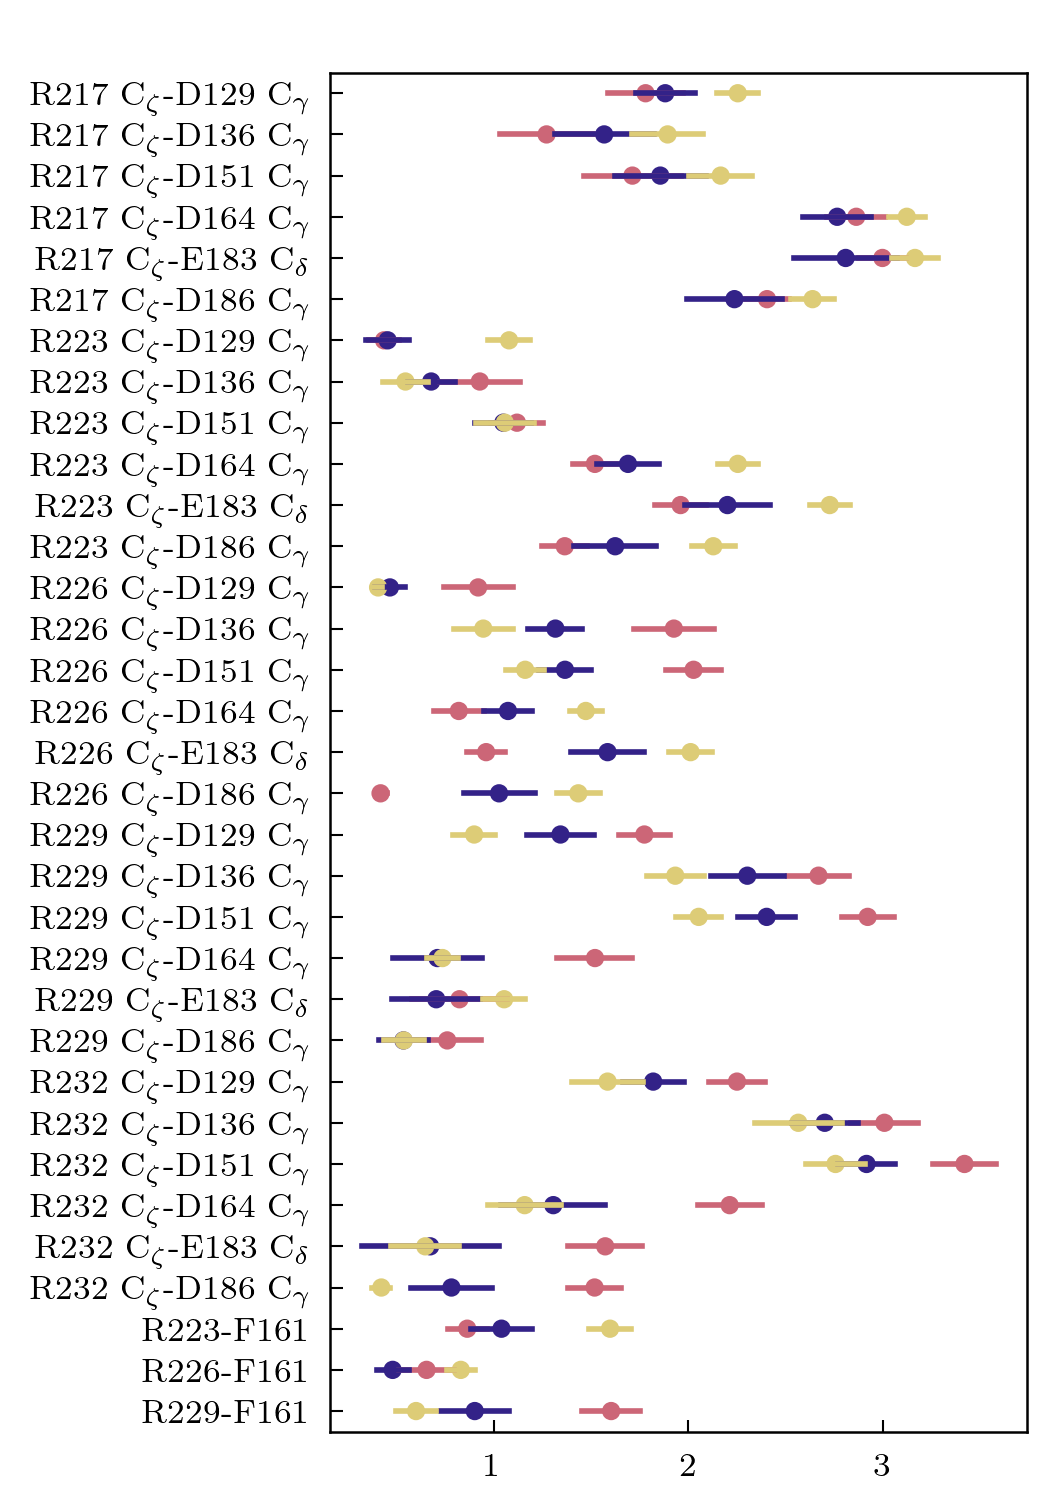

In [18]:
f = plt.figure(figsize=(3, 6), dpi=300)
ax = plt.gca()
sns.pointplot(data=down_cv[:, 2:], join=False, ci='sd', orient='h', alpha=0.5)
sns.pointplot(data=ts_cv[:, 2:], join=False, ci='sd', orient='h', color='C1', alpha=0.5)
sns.pointplot(data=up_cv[:, 2:], join=False, ci='sd', orient='h', color='C2', alpha=0.5)
_ = plt.yticks(ticks=np.arange(33), labels=feature_names[2:])
pplt.legend(outside='top')

In [29]:
cvs = pd.DataFrame(data=cv_arr, columns=["Translocation", "Rotation"])

In [40]:
cvs['State'] = ""
cvs['State'][down_ids] = "Down"
cvs['State'][up_ids] = "Up"
cvs['State'][q_inds[0]] = "TS"

/scratch/local/jobs/4690200/ipykernel_236204/2251438901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvs['State'][down_ids] = "Down"
/scratch/local/jobs/4690200/ipykernel_236204/2251438901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvs['State'][up_ids] = "Up"
/scratch/local/jobs/4690200/ipykernel_236204/2251438901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvs['State'][q_inds[0]] = "TS"


In [53]:
cvs

,Translocation,Rotation,State
0,-5.795,-84.424,
1,-5.636,-86.856,
2,-6.238,-88.460,
3,-5.719,-81.653,
4,-5.844,-83.083,
...,...,...,...
4150110,-1.458,-60.621,
4150111,-1.649,-63.467,
4150112,-1.522,-58.446,
4150113,-1.043,-60.213,


In [52]:
sns.pointplot(data=cvs, x="Translocation", y="Rotation", hue="State", dodge=True, join=False, ci='sd', orient='h', alpha=0.5)
# sns.pointplot(data=ts_cv[:, 0], join=False, ci='sd', orient='h', color=ts_col, alpha=0.5, ax=ax1)
# sns.pointplot(data=up_cv[:, 0], join=False, ci='sd', orient='h', color=up_col, alpha=0.5, ax=ax1)
# ax1.set_yticks(ticks=[0], labels=[f"{feature_names[0]} / Å"])

KeyboardInterrupt: 

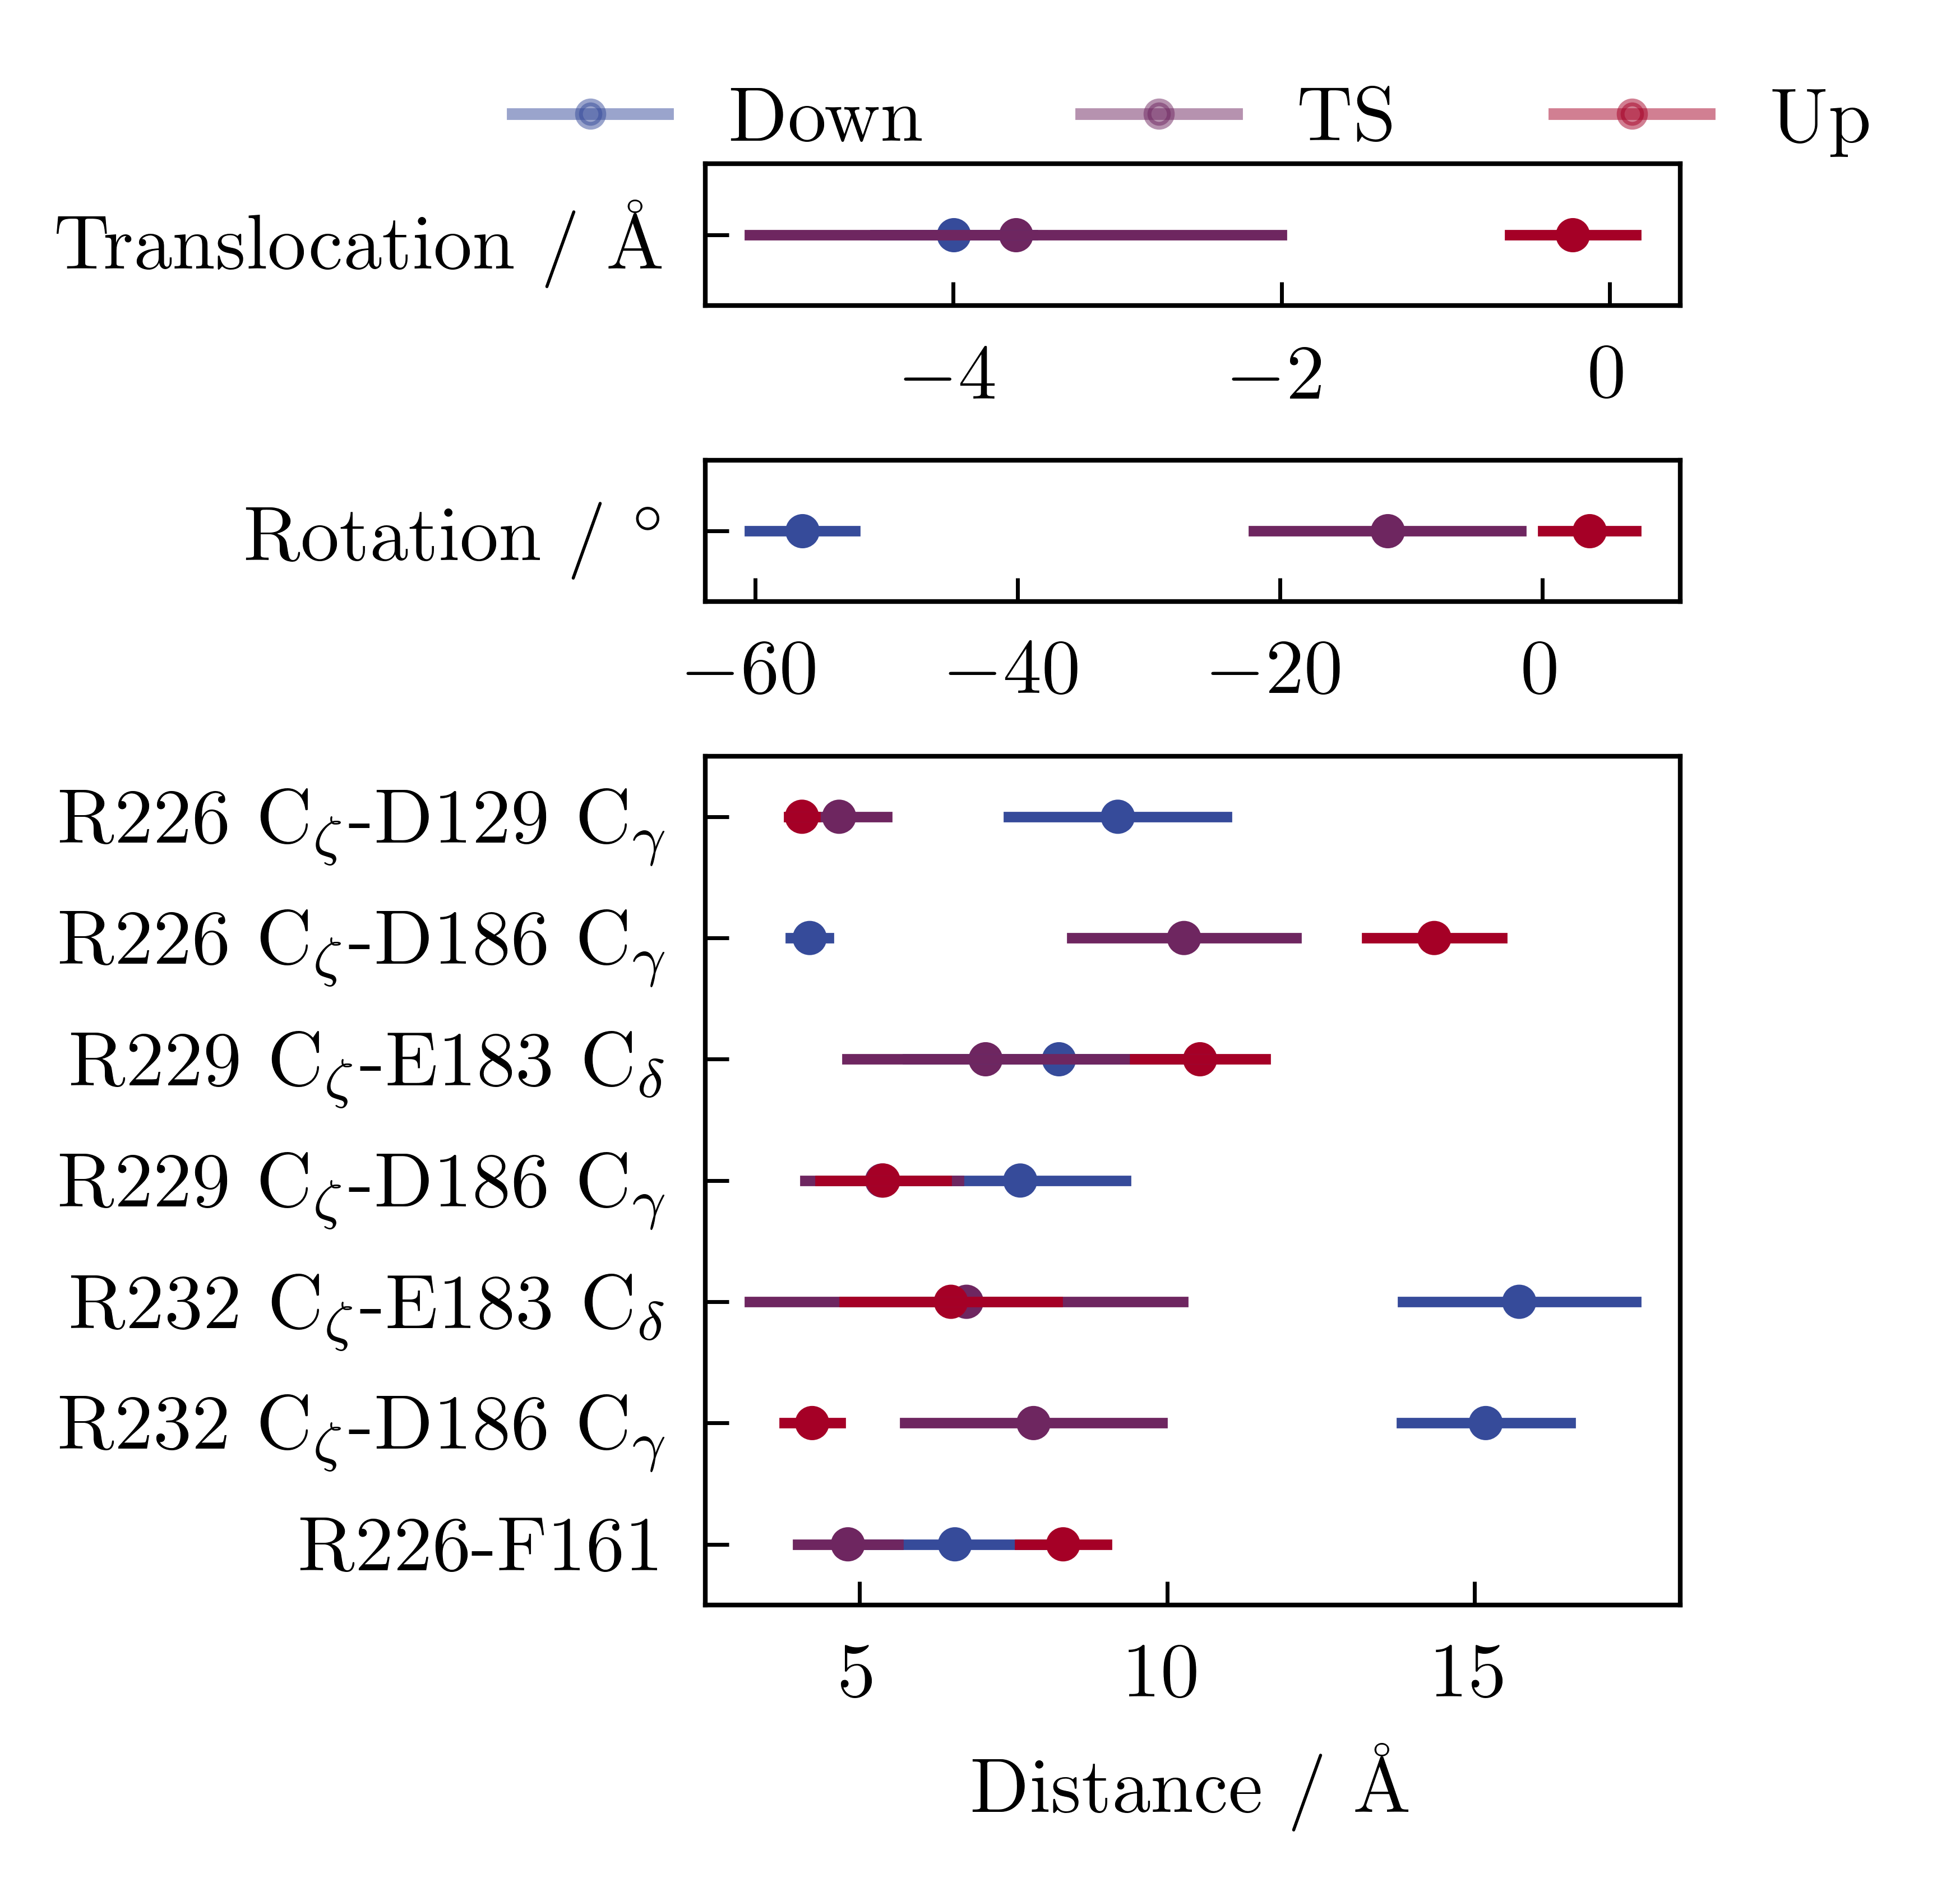

In [23]:
f = plt.figure(figsize=(3.25, 3.25), dpi=500, constrained_layout=True)
gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[1, 1, 6], figure=f)
ax1 = f.add_subplot(gs[0])
ax2 = f.add_subplot(gs[1])
ax3 = f.add_subplot(gs[2])

down_col = "#364B9A"
# ts_col = "#EAECCC"
ts_col = "#6e2660"
up_col = "#A50026"

# translocation
sns.pointplot(data=down_cv[:, 0], join=False, ci='sd', orient='h', color=down_col, alpha=0.5, ax=ax1)
sns.pointplot(data=ts_cv[:, 0], join=False, ci='sd', orient='h', color=ts_col, alpha=0.5, ax=ax1)
sns.pointplot(data=up_cv[:, 0], join=False, ci='sd', orient='h', color=up_col, alpha=0.5, ax=ax1)
ax1.set_yticks(ticks=[0], labels=[f"{feature_names[0]} / Å"])

# rotation
sns.pointplot(data=down_cv[:, 1], join=False, ci='sd', orient='h', color=down_col, alpha=0.5, ax=ax2)
sns.pointplot(data=ts_cv[:, 1], join=False, ci='sd', orient='h', color=ts_col, alpha=0.5, ax=ax2)
sns.pointplot(data=up_cv[:, 1], join=False, ci='sd', orient='h', color=up_col, alpha=0.5, ax=ax2)
ax2.set_yticks(ticks=[0], labels=[f"{feature_names[1]} / $^\circ$"])

# other CVs
other_ids = [14, 19, 24, 25, 30, 31, 33]
other_names = [feature_names[i] for i in other_ids]
sns.pointplot(data=down_cv[:, other_ids] * 10, join=False, dodge=1, ci='sd', orient='h', color=down_col, ax=ax3)
sns.pointplot(data=ts_cv[:, other_ids] * 10, join=False, ci='sd', orient='h', color=ts_col, ax=ax3)
sns.pointplot(data=up_cv[:, other_ids] * 10, join=False, ci='sd', orient='h', color=up_col, ax=ax3)
ax3.set_yticks(ticks=np.arange(len(other_ids)), labels=other_names)
ax3.set_xlabel("Distance / Å")

# ax3.tick_params(axis='y', length=0)

# sns.despine(fig=f, left=True, right=True)

blue_line = mpl.lines.Line2D([], [], color=down_col, marker='.', markersize=6, linewidth=1.5, label='Down')
yellow_line = mpl.lines.Line2D([], [], color=ts_col, marker='.', markersize=6, linewidth=1.5, label='TS')
red_line = mpl.lines.Line2D([], [], color=up_col, marker='.', markersize=6, linewidth=1.5, label='Up')
ax1.legend(bbox_to_anchor=[0.5, 1.3], loc='center', ncol=3, handles=[blue_line, yellow_line, red_line])

## Larger TS bin

In [8]:
steps, q_inds = bin_inds(q, qstep=0.2, low=0.4, hi=0.6)

In [13]:
ts_cv =  X[q_inds[0]]
ts_avgs = np.mean(ts_cv, axis=0)

In [14]:
ts_cv.shape

(359201, 35)

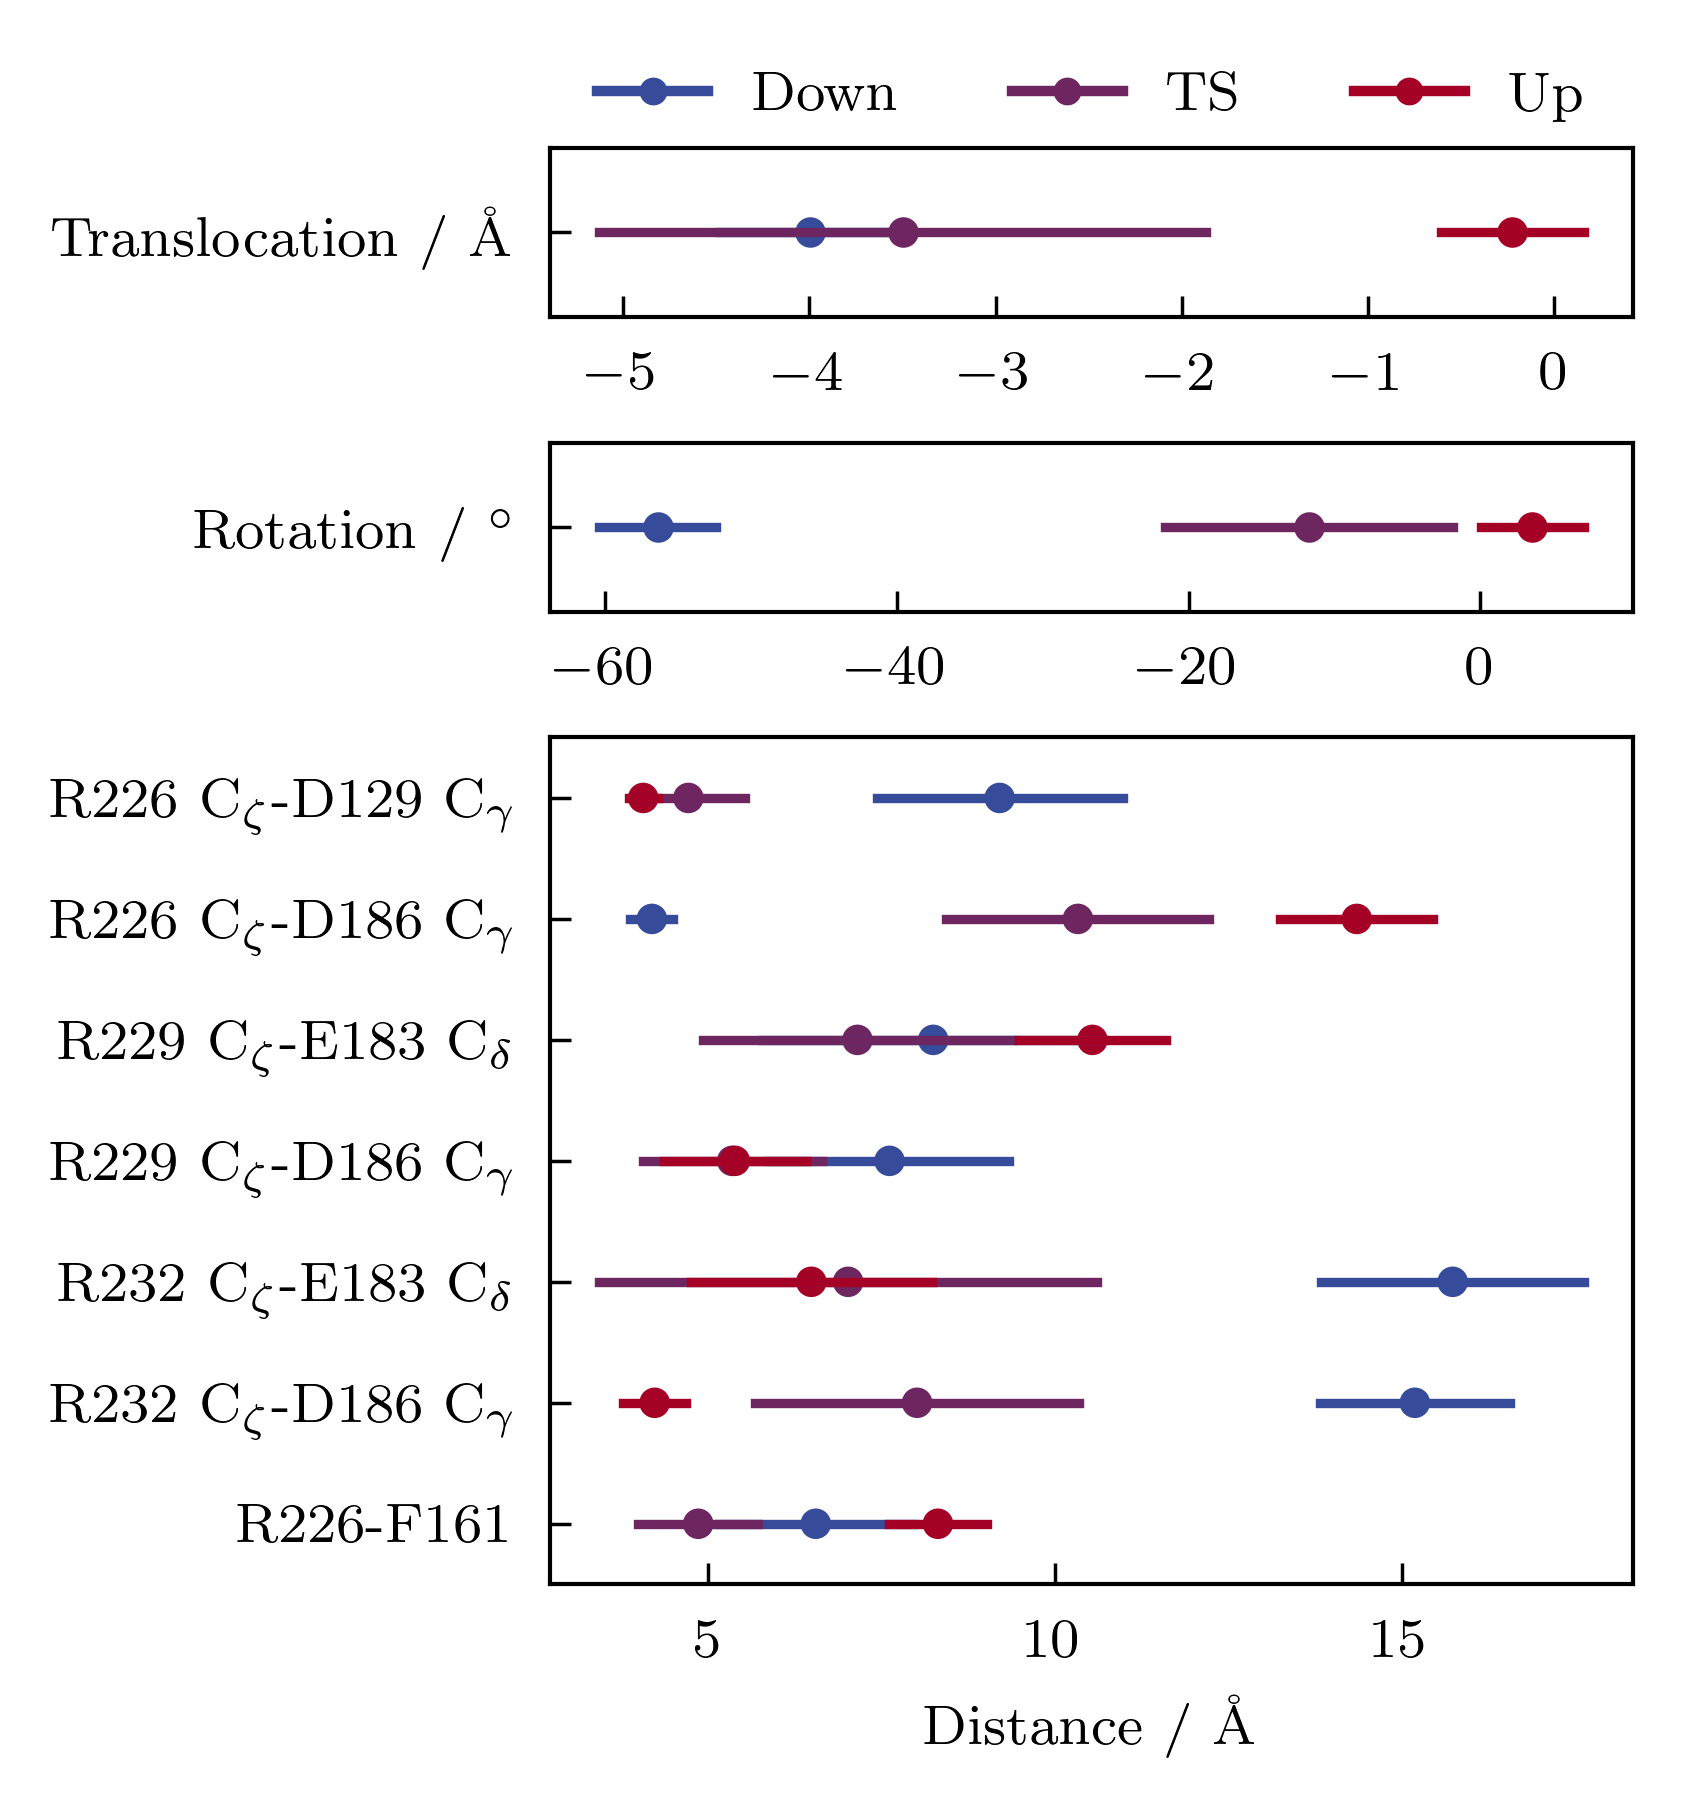

In [19]:
f = plt.figure(figsize=(3.25, 3.5), dpi=500, constrained_layout=True)
gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[1, 1, 5], figure=f)
ax1 = f.add_subplot(gs[0])
ax2 = f.add_subplot(gs[1])
ax3 = f.add_subplot(gs[2])

down_col = "#364B9A"
# ts_col = "#EAECCC"
ts_col = "#6e2660"
up_col = "#A50026"

# translocation
sns.pointplot(data=down_cv[:, 0], join=False, ci='sd', orient='h', color=down_col, ax=ax1)
sns.pointplot(data=ts_cv[:, 0], join=False, ci='sd', orient='h', color=ts_col, ax=ax1)
sns.pointplot(data=up_cv[:, 0], join=False, ci='sd', orient='h', color=up_col, ax=ax1)
ax1.set_yticks(ticks=[0], labels=[f"{feature_names[0]} / Å"])

# rotation
sns.pointplot(data=down_cv[:, 1], join=False, ci='sd', orient='h', color=down_col, ax=ax2)
sns.pointplot(data=ts_cv[:, 1], join=False, ci='sd', orient='h', color=ts_col, ax=ax2)
sns.pointplot(data=up_cv[:, 1], join=False, ci='sd', orient='h', color=up_col, ax=ax2)
ax2.set_yticks(ticks=[0], labels=[f"{feature_names[1]} / $^\circ$"])

# other CVs
other_ids = [14, 19, 24, 25, 30, 31, 33]
other_names = [feature_names[i] for i in other_ids]
sns.pointplot(data=down_cv[:, other_ids] * 10, join=False, ci='sd', orient='h', color=down_col, ax=ax3)
sns.pointplot(data=ts_cv[:, other_ids] * 10, join=False, ci='sd', orient='h', color=ts_col, ax=ax3)
sns.pointplot(data=up_cv[:, other_ids] * 10, join=False, ci='sd', orient='h', color=up_col, ax=ax3)
ax3.set_yticks(ticks=np.arange(len(other_ids)), labels=other_names)
ax3.set_xlabel("Distance / Å")

blue_line = mpl.lines.Line2D([], [], color=down_col, marker='.', markersize=6, linewidth=1.5, label='Down')
yellow_line = mpl.lines.Line2D([], [], color=ts_col, marker='.', markersize=6, linewidth=1.5, label='TS')
red_line = mpl.lines.Line2D([], [], color=up_col, marker='.', markersize=6, linewidth=1.5, label='Up')
ax1.legend(bbox_to_anchor=[0.5, 1.3], loc='center', ncol=3, handles=[blue_line, yellow_line, red_line])